<a href="https://colab.research.google.com/github/Pavan042/Facial_recognition_CNN_OpenCV/blob/main/Facial_expression_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Recognition using Facial Expressions

In [ ]:
Connecting to Drive and changing directories

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import io
import zipfile

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/DS_projects/Fer_data/fer2013

[Errno 2] No such file or directory: 'drive/MyDrive/DS_projects/Fer_data/fer2013'
/content/drive/MyDrive/DS_projects/Fer_data/fer2013




##   Importing Required Libraries



In [ ]:
import math
import numpy as np
import pandas as pd

!pip install sklearn
!pip install scikit-plot

import cv2
import scikitplot
import seaborn as sns
import matplotlib
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense , Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Preprocessing

In [ ]:
#Reading the csc files using Pandas
df = pd.read_csv('fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [ ]:
#Text to numerical labeling
emotion_label_to_text = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Suprise', 6:'Neutral'}

In [ ]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
# Calculate the side length of the images
math.sqrt(len(df.pixels[0].split(' ')))

48.0

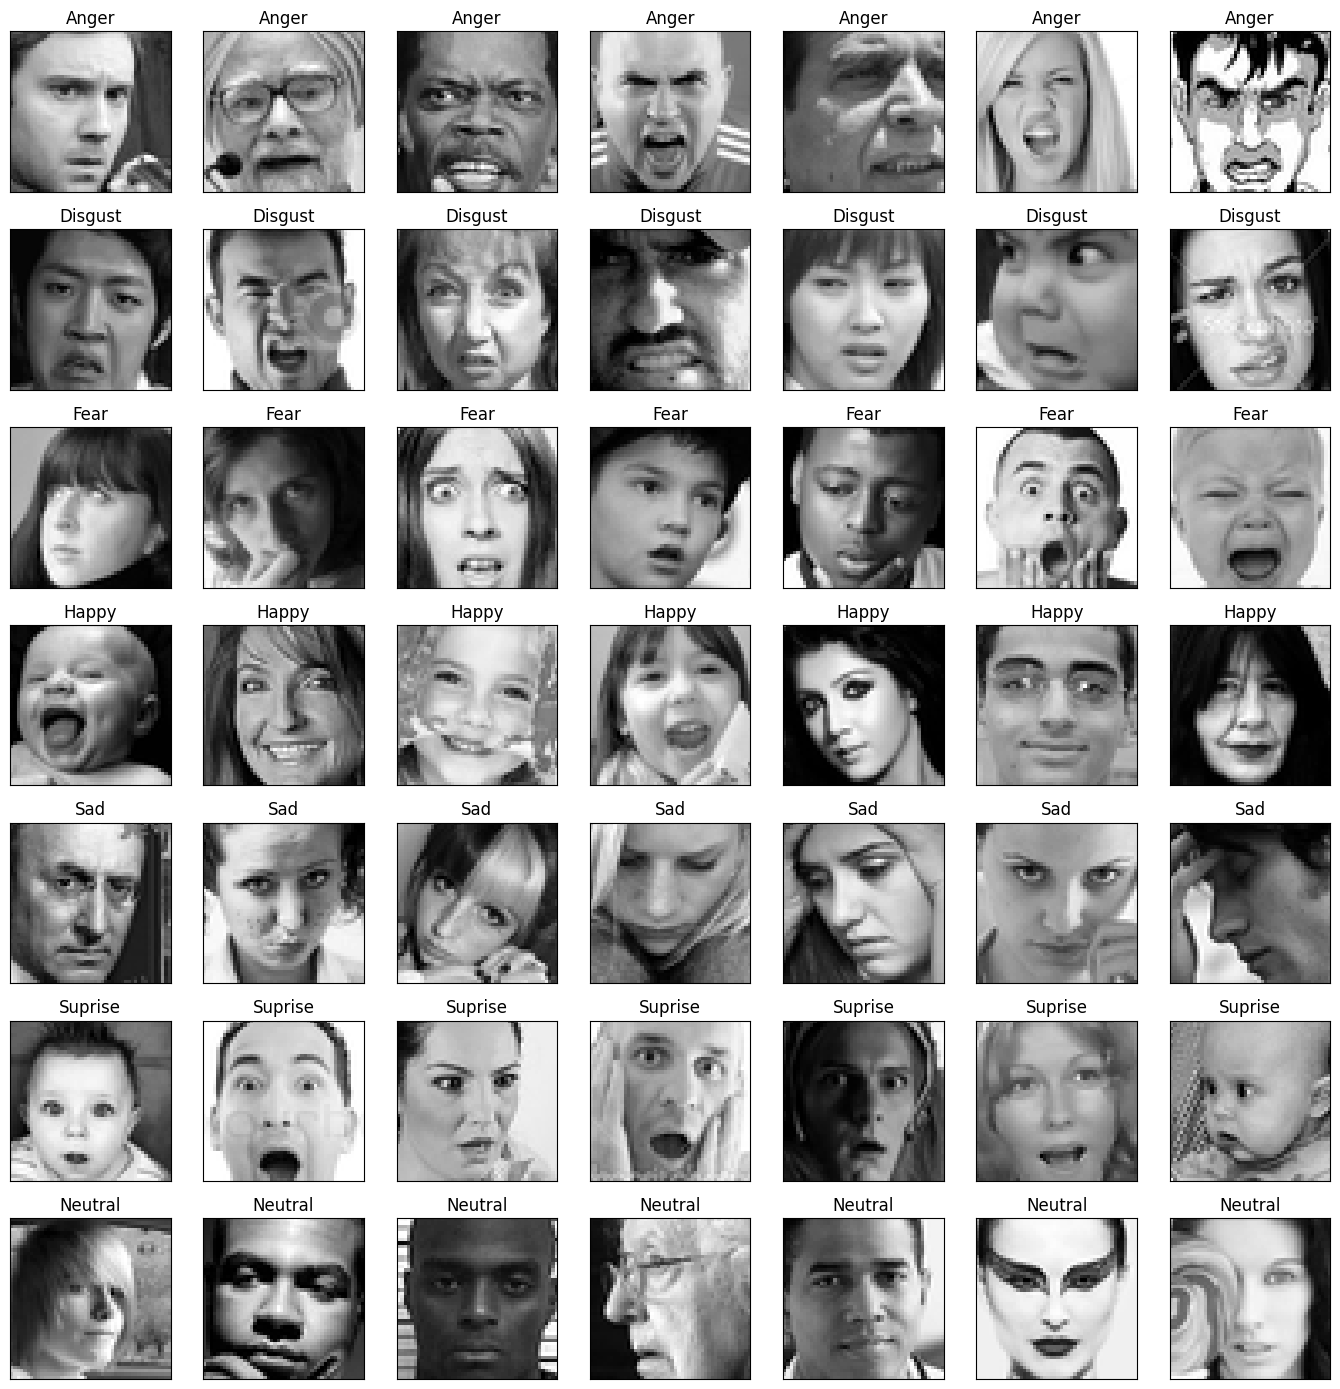

In [ ]:
# Viewing and Understanding the images
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
  for j in range(7):
    px = df[df.emotion == label].pixels.iloc[k]
    px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
    k += 1
    ax = pyplot.subplot(7,7,k)
    ax.imshow(px, cmap = 'gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotion_label_to_text[label])
    pyplot.tight_layout()

Genric information on the above code:


* fig=pyplot.figure(1,(14,14)): This line creates a new figure with Figure number 1 and dimensions of 14 inches by 14 inches.

* k=0: This initializes a counter variable k to zero.
* for label in sorted(df.emotion.unique()): This loops over the unique emotion labels in the emotion column of the df DataFrame, sorted in ascending order.
* for j in range(7): This nested loop creates 7 columns of subplots for each emotions category.
* px = df[df.emotion==label].pixels.iloc[k]: This line selects the k-th image from the pixels column to the df DataFrame that belongs to the current label emotion category, and stores it in a variable px.
* px=np.array(px.split('')).reshape(48,48).astype('float32'): This line converts the string of pixel values into Numpy Array, Reshapes it into a 48*48 array, and converts it into a float32 data type.
* k +=1: Increments the k counter by 1.
* ax=pyplot.subplot(7,7,k): This creates a new subplot with a 7*7 grid layout, and selects the k-th subplot as the current one to plot the current image.
* ax.imshow(px,cmap = 'gray'): This displays the image data stored in px on the current subplot, using a grayscale color map.
* ax.set_title(emotion_label_to_text[label]): This sets the title of the current subplot to the corresponding emotion label, as specified in a dictionary emotion_label_to_text.
* pyplot.tight_layout(): This adjusts the layout of the subplots to prevent overlapping.



### Now lets make the data ready for neural networks.

The data in df contains pixel values which are stored as strings, hence we need to convert them to array.

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

* img_array = df.pixels.apply(lambda x: np.array(x.split('')).reshape(48,48).astype('float32')): This line uses the Pandas apply() function to apply a lambda function that splits the string of pixel values into an array of strings using the space character as a delimiter, converts the resulting array into a 48*48 NumPy Array of float32 data type, and returns the array. Here the output is Pandas Series of NumPy arrays.
* img_array = np.stack(img_array, axis=0): This line uses the NumPy stack() function to stack the array in the Pandas Series along the 0th axis, creating a 3D NumPy array of shape(n_samples, 48,48), where n_samples is the number of samples in the original DataFrame This creates a NumPy array of image data that can be used as input for machine learning models.

In [ ]:
#View the shape of image array created using above code.
img_array.shape

(35887, 48, 48)

In [ ]:
img_features = []

for i in range(len(img_array)):
  temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
  img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


* Here each grayscale image in img_array is converted to an RBG image using OpenCV's cvtColor() function with the COLOR_GRAY2RGB flag. This results in a list of RBG images stored in img_features.

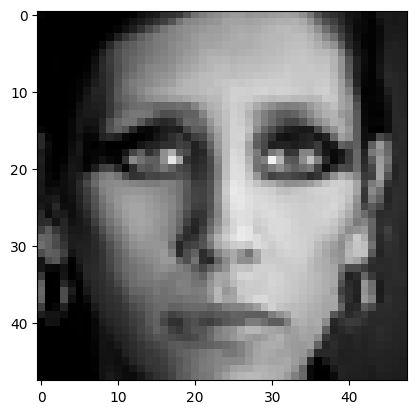

In [ ]:
#Printing an image from img_features
pyplot.imshow(img_features[4].astype(np.uint8));

* One might think that the above image is Black & White even when we converted it to 4D with RGB channels. This is because the image is actually black and white, if the original grayscale was predominantly black and white then the resulting img would be created by duplicating the grayscale values hence resulting in black and white in all RBG color channels.

In [ ]:
le = LabelEncoder()

img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(35887, 7)

* The LabelEncoder belongs to a class from Scikit-learn it is used to convert the categorical label in the df.emotion column to numerical labels, which are then converted to one-hot encoding binary vectors using the np_utils.to_categorical() function from Keras. The resulting img_labels array is a 2D NumPy array of shape (n_samples, n_classes), where n_samples is the number of images in the dataset and n_classes is the corresponding numbers to the emotions in the dataset.

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


* This code block creates a disctionary le_name_mapping that maps each unique label in the df.emotion column to a numerical label using the LabelEncoder class from the Scikit-learn.
* The zip() function is used to pair each unique label with its corresponding numberical label, which is obtained using the le.tranform() method of LabelEncoder object le. The resulting pairs are then passed to the dict() function to create a dictionary that maps each unique label to its numerical label.
* The resulting le_name_mapping dictionary can be useful for interpreting the output of a machine learning model that used the numerical labels as it predicted outputs. By mapping the predicted numerical label we can interpret the output of the model in terms of original categories.
* For example, if the model predicts numerical label of 3, we can use le.invers_tranform([3]) to obtain its categorical label, as 'Happy'.

In [ ]:
#Spliting the data into Train and Test
X_train, X_valid, Y_train, Y_valid = train_test_split(img_features, img_labels, shuffle = True, stratify = img_labels, test_size = 0.1, random_state = 42)
X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [ ]:
del df
del img_features
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = Y_train.shape[1]

In [ ]:
#Here we normalize the results since neural networks and very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
# Loading VGG19 convolutinal neural network (CNN) form Keras
vgg = tf.keras.applications.VGG19(weights = 'imagenet', include_top = False, input_shape = (48, 48, 3))

In [ ]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [ ]:
def build_model(bottom_model, classes):
  model = bottom_model.layers[-2].output
  model = GlobalAveragePooling2D()(model)
  model = Dense(classes, activation = 'softmax', name = 'output_layer')(model)

  return model

* The function first takes the output of the second-to-last layer of the pre-trained mdoel, which contains high-level features learned from the input images, and passes it through a global average pooling layer. This layer takes the average of each feature map in the input and reduces the spatial dimensions of the outpu to 1*1, while retaining the Channel dimension.

The output of the global average pooling layer is then passed throught a fully connected Dense layer with a softmax activation function, which outputs a probability distribution over the possible classes of facial emotions.

The resulting model has all layers of the pre-trained model frozen, and only the newly added layers are trainable. This is because the pre-trained weights are already optimized for a specific task(image classification on ImageNet), and we want to preserve these weights while only adjusting the new layers for the task of facial emotion recognition.

In [ ]:
head = build_model(vgg, num_classes)
model = Model(inputs = vgg.input, outputs = head)
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [ ]:
#Early stopping for avoiding overfitting training data and ReduceLROnPlateau for learning rate.
early_stopping = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.00005, patience = 11, verbose = 1, restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, min_lr = 1e-7, verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

In [ ]:
#Generating more training data
train_datagen = ImageDataGenerator(rotation_range = 15, width_shift_range = 0.15, height_shift_range = 0.15, shear_range = 0.15, zoom_range = 0.15, horizontal_flip = True,)
train_datagen.fit(X_train)

In [ ]:
batch_size = 48
epochs = 30
optims = [optimizers.Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy', optimizer = optims[0], metrics = ['accuracy'])


* Here the code sets the hyperparameters for training the facial emotion recognition model.
* batch_size specifies the number of samples to use in each iteration of training. In this case, 48 samples will be used in each iteration.
* epochs specifies the number of times to iterate over the entire training dataset. In this case, the model will be trained for 30 epochs.
* optims is a list of optimizers to use during training. In this case, it contains a single optimizer:Adam. It is a popular optimizer that adapts the learning rate during training based on the gradient history.
* And at last, the code compiles the model with the specified loss function (categorical_crossentrophy),optimizer (optims[0]), and metric to evalute during traning is (accuracy).

In [ ]:
history = model.fit(train_datagen.flow(X_train, Y_train, batch_size = batch_size), validation_data = (X_valid, Y_valid), steps_per_epoch = len(X_train)/ batch_size, epochs = epochs, callbacks = callbacks, use_multiprocessing = True)

Epoch 1/30
672/672 [==============================] - 77s 103ms/step - loss: 1.4733 - accuracy: 0.4227 - val_loss: 1.3583 - val_accuracy: 0.4857 - lr: 1.0000e-04
Epoch 2/30
672/672 [==============================] - 67s 100ms/step - loss: 1.2367 - accuracy: 0.5301 - val_loss: 1.1057 - val_accuracy: 0.5754 - lr: 1.0000e-04
Epoch 3/30
672/672 [==============================] - 64s 95ms/step - loss: 1.1511 - accuracy: 0.5628 - val_loss: 1.0670 - val_accuracy: 0.6004 - lr: 1.0000e-04
Epoch 4/30
672/672 [==============================] - 63s 93ms/step - loss: 1.0994 - accuracy: 0.5822 - val_loss: 1.0802 - val_accuracy: 0.6010 - lr: 1.0000e-04
Epoch 5/30
672/672 [==============================] - 63s 94ms/step - loss: 1.0461 - accuracy: 0.6060 - val_loss: 1.0218 - val_accuracy: 0.6069 - lr: 1.0000e-04
Epoch 6/30
672/672 [==============================] - 61s 91ms/step - loss: 1.0129 - accuracy: 0.6197 - val_loss: 1.0159 - val_accuracy: 0.6266 - lr: 1.0000e-04
Epoch 7/30
672/672 [============

In [ ]:
model_yaml = model.to_json()
with open("model.yaml","w") as yaml_file:
  yaml_file.write(model_yaml)

model.save("model.h5")

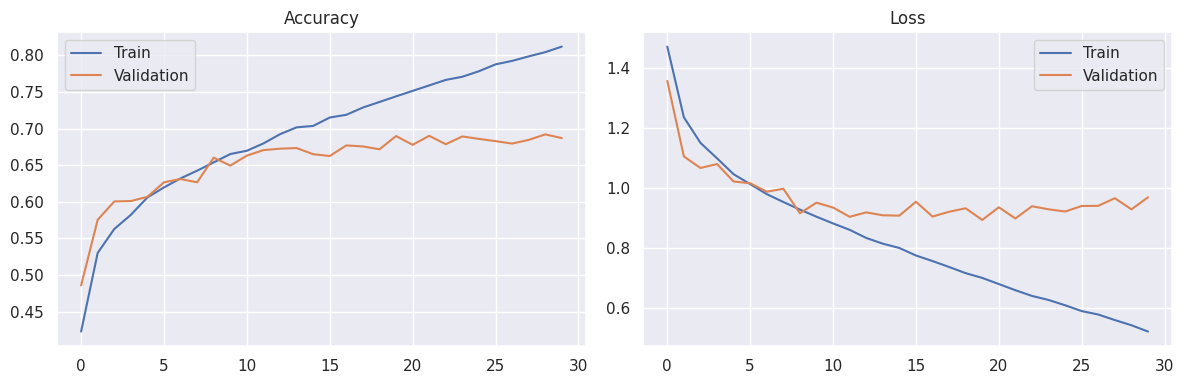

In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax =  pyplot.subplot(1, 2, 1)
sns.lineplot(x = history.epoch, y = history.history['accuracy'], label = 'Train')
sns.lineplot(x = history.epoch, y = history.history['val_accuracy'], label = 'Validation')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x = history.epoch, y = history.history['loss'], label = 'Train')
sns.lineplot(x = history.epoch, y = history.history['val_loss'], label = 'Validation')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('Epoch_history_CNN.png')
pyplot.show()

113/113 [==============================] - 2s 16ms/step
Total Wrong Validation Predictions: 1123


              precision    recall  f1-score   support

           0       0.61      0.62      0.62       495
           1       0.64      0.62      0.63        55
           2       0.58      0.50      0.53       512
           3       0.88      0.87      0.87       899
           4       0.56      0.55      0.56       608
           5       0.87      0.72      0.79       400
           6       0.60      0.75      0.67       620

    accuracy                           0.69      3589
   macro avg       0.68      0.66      0.67      3589
weighted avg       0.69      0.69      0.69      3589



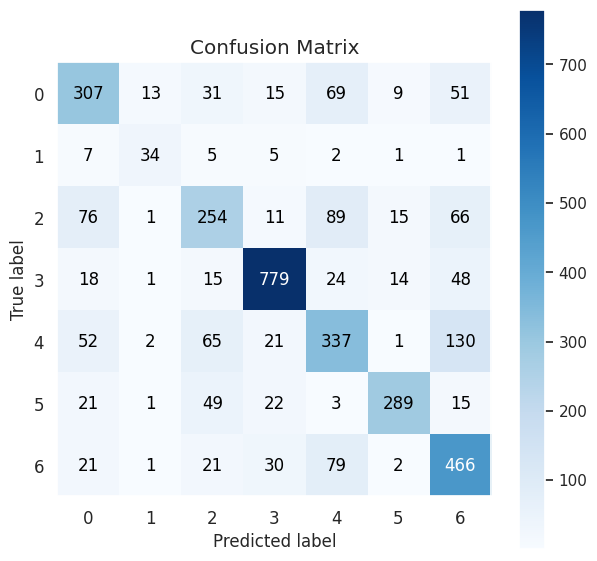

In [ ]:
hat_valid = np.argmax(model.predict(X_valid), axis = 1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(Y_valid, axis = 1), hat_valid, figsize = (7,7))
pyplot.savefig("Confusion_matrix_CNN.png")

print(f'Total Wrong Validation Predictions: {np.sum(np.argmax(Y_valid, axis = 1) != hat_valid)}\n\n')
print(classification_report(np.argmax(Y_valid, axis = 1), hat_valid))

The confusion matrix indicates that our model is performing well on the "Happy" class, but its performance is lacking on other clasees. A potential explaination for this could be the limited amount of data available for these classes. However, upon reviewing the images, you may notice that certian images were even challenging for a human to differentiate between "Sad" and "Neutral". Additionally. Facial expression can vary among people, some people's neutral face may appear as angry or sad.

In [ ]:
mapper = {
    0: 'Anger',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Suprise',
    6: 'Neutral'
}

1/1 [==============================] - 0s 24ms/step


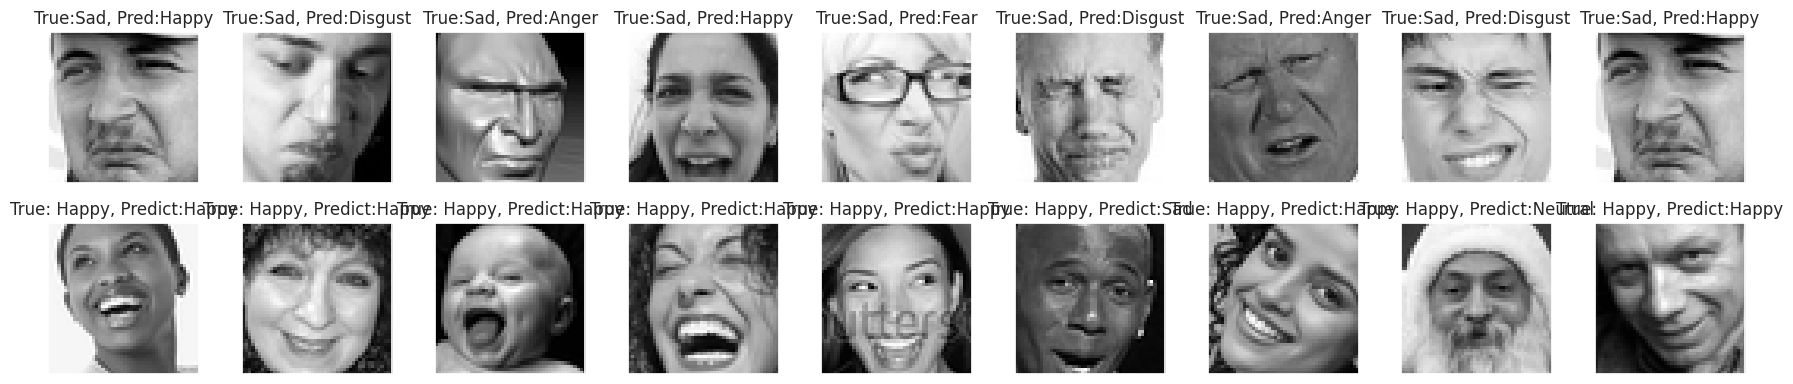

In [ ]:
np.random.seed(2)
random_sad_img = np.random.choice(np.where(Y_valid[:, 1]==1)[0], size = 9)
random_happy_img = np.random.choice(np.where(Y_valid[:, 3]==1)[0], size = 9)

fig = pyplot.figure(1, (18, 4))
for i, (sadidx,hapidx) in enumerate(zip(random_sad_img, random_happy_img)):
  ax = pyplot.subplot(2, 9, i+1)
  sample_img = X_valid[sadidx,:,:,0]
  ax.imshow(sample_img, cmap = 'gray')
  ax.set_xticks([])
  ax.set_yticks([])
  sample_img = cv2.cvtColor(sample_img, cv2.COLOR_GRAY2RGB)

  ax.set_title(f"True:Sad, Pred:{mapper[np.argmax(model.predict(sample_img.reshape(1, 48, 48, 3))[0])]}")


  ax = pyplot.subplot(2, 9, i+10)
  sample_img = X_valid[hapidx,:,:,0]
  ax.imshow(sample_img, cmap = 'gray')
  ax.set_xticks([])
  ax.set_yticks([])
  sample_img = cv2.cvtColor(sample_img,cv2.COLOR_GRAY2RGB)

  ax.set_title(f"True: Happy, Predict:{mapper[np.argmax(model.predict(sample_img.reshape(1, 48, 48, 3))[0])]}")
  pyplot.tight_layout()

Actual Label is Sad
1/1 [==============================] - 0s 20ms/step
Predicted Label is Sad


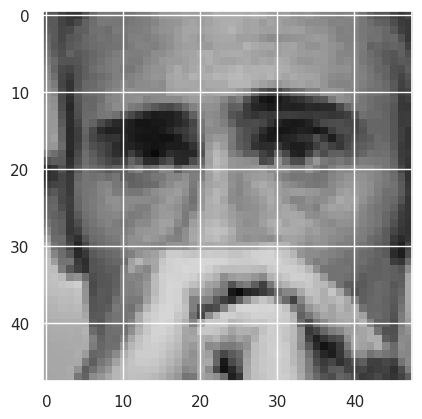

In [ ]:
from IPython.display import clear_output
import time
for k in range(40):
  print(f'Actual Label is {mapper[np.argmax(Y_valid[k])]}')
  predicted = model.predict(tf.expand_dims(X_valid[k],0)).argmax()
  print(f'Predicted Label is {mapper[predicted]}')
  pyplot.imshow(X_valid[k])
  pyplot.show()
  time.sleep(5)
  clear_output(wait=True)
